In [8]:
from sim_data import *
from fit_exp import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# set seed for reproducibility
np.random.seed(100)

# iIRF parameters
rep_rate = 40
k = 512
fwhm = 0.2

# iIRF only needs to be generated once
# it is measured one time and the sa
# me for all signals
iirf, t = gaussian_irf(rep_rate, k, fwhm)

nonZeroIdx = np.argmin(np.abs(iirf[:int(len(iirf)/2)] - 1/20))
iirf_aligned = 0.5 * np.roll(iirf, -nonZeroIdx)

# number of sets to generate
N = 100

In [9]:
from compute_V import *
from laguerre_basis import *
from compute_tau import * 

In [10]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
# fractional contributions and taus randomly generated
# in this case, based on the information in the paper,
# fractional contributions are generated from a uniform distribution between 
# 0 and 100%
# and taus are randomly generated from a uniform distribution between 1 and 6 ns
# and the number of exponential components generated is randomly picked from 1-6
rng = np.random.default_rng(100)
M = rng.integers(low=1, high=6, size=N)
# TODO order fracs and taus correctly for input into gen_signal
parts = [rng.random(m) for m in M]
fracs = [parts[n] / sum(parts[n]) for n in range(N)]
taus = [rng.uniform(low = 1, high = 6, size = m) for m in M]

In [12]:
def do_prediction(k, alpha, L, dt, iirf, decay):
    V = compute_V(k, alpha, L, iirf)
    B = basis_array(k, alpha, L)
    regr = linear_model.LinearRegression()
    pred_taus = []
    regr.fit(V,decay)
    taus = compute_tau_avg(regr.coef_, dt, B, k) * 1e9

    return taus

decays = []
avg_taus = []
exp_avg_taus = []
lag_avg_taus = []
errors = 0
for n in range(N):
    try:
        decay, t, avg_lts = gen_signal(rep_rate, k, fracs[n], taus[n], iirf)
        noisy_decay = add_white_noise(decay, 20)

        exp_a, exp_taus, _ = fit_exp(t, noisy_decay,2)
        exp_avg_taus.append(np.average(exp_taus, weights=exp_a))

        lag_avg_taus.append(do_prediction(len(t), 0.9336, 8, t[1]-t[0], iirf, decay))
        decays.append(noisy_decay)
        avg_taus.append(avg_lts)

    except:
        errors += 1  


Text(0.5, 1.0, 'Exponential vs. Laguerre')

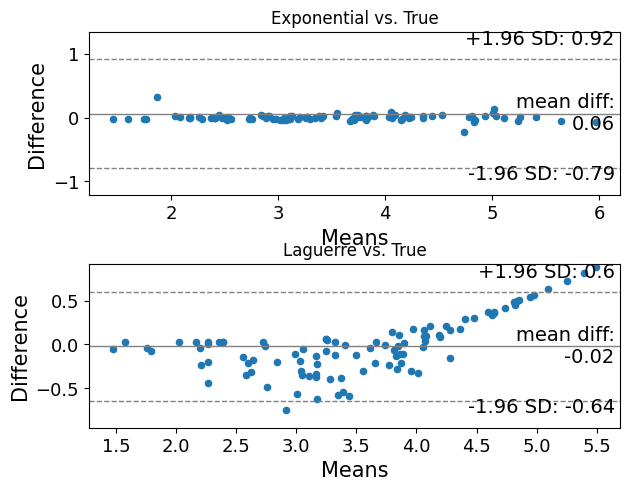

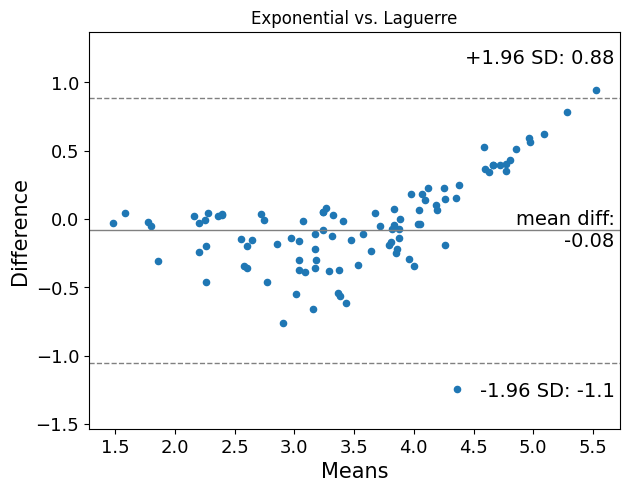

In [17]:
import statsmodels.api as sm
badIdx = np.asarray(avg_taus) > 10
avg_taus = np.asarray(avg_taus)
exp_avg_taus = np.asarray(exp_avg_taus)
lag_avg_taus = np.asanyarray(lag_avg_taus)

avg_taus = avg_taus[exp_avg_taus < 10]
lag_avg_taus = lag_avg_taus[exp_avg_taus < 10]
exp_avg_taus = exp_avg_taus[exp_avg_taus < 10]

fig1, (expax, lagax) = plt.subplots(2)
fig2, ax = plt.subplots(1)


sm.graphics.mean_diff_plot(np.asarray(avg_taus), np.asarray(exp_avg_taus), ax=expax)
sm.graphics.mean_diff_plot(np.asarray(avg_taus), np.asarray(lag_avg_taus), ax=lagax)
expax.set_title("Exponential vs. True")
lagax.set_title("Laguerre vs. True")

sm.graphics.mean_diff_plot(exp_avg_taus, lag_avg_taus, ax=ax)
ax.set_title("Exponential vs. Laguerre")